In [1]:
import datetime as dt

from Pandora.helper import TDays
from Pandora.research.backtest import calc_sharpe, COMMISSION
from Pandora.constant import Interval, Product
from vnpy.trader.optimize import OptimizationSetting
from vnpy.trader.setting import SETTINGS
from logging import INFO
from vnpy.app.vnpy_portfoliostrategy import BacktestingEngine

SETTINGS["log.active"] = True
SETTINGS["log.level"] = INFO
SETTINGS["log.console"] = True



In [2]:
def get_mc(codes):
    from vnpy.trader.database import get_database

    database = get_database()
    today = dt.datetime.combine(TDays.get_tday(fmt=None, end_hour=23), dt.time(0))
    contracts = database.load_contract_data(product=Product.FUTURES, start=today, end=today)
    mc = [i for i in contracts if i.symbol.endswith('00') and i.product_id in codes]

    return mc


## DataLoading

In [4]:
from Pandora.research import CODES_MM

mc = get_mc(CODES_MM)

engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=dt.datetime(2015, 1, 1),
    end=dt.datetime.now(),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



2024-07-06 21:08:00.161140	开始加载历史数据
2024-07-06 21:08:00.633875	AP00.CZCE历史数据加载完成，数据量：23760
2024-07-06 21:08:01.092171	CF00.CZCE历史数据加载完成，数据量：54477
2024-07-06 21:08:01.607342	FG00.CZCE历史数据加载完成，数据量：53447
2024-07-06 21:08:02.116027	MA00.CZCE历史数据加载完成，数据量：54477
2024-07-06 21:08:02.292060	SA00.CZCE历史数据加载完成，数据量：24777
2024-07-06 21:08:02.711454	SR00.CZCE历史数据加载完成，数据量：54477
2024-07-06 21:08:03.159802	TA00.CZCE历史数据加载完成，数据量：54477
2024-07-06 21:08:03.704304	al00.SHFE历史数据加载完成，数据量：69609
2024-07-06 21:08:04.160099	bu00.SHFE历史数据加载完成，数据量：54633
2024-07-06 21:08:04.560029	c00.DCE历史数据加载完成，数据量：44113
2024-07-06 21:08:04.839786	fu00.SHFE历史数据加载完成，数据量：38669
2024-07-06 21:08:05.319009	hc00.SHFE历史数据加载完成，数据量：54633
2024-07-06 21:08:05.689019	i00.DCE历史数据加载完成，数据量：55091
2024-07-06 21:08:06.200158	j00.DCE历史数据加载完成，数据量：55091
2024-07-06 21:08:06.590115	jm00.DCE历史数据加载完成，数据量：55091
2024-07-06 21:08:06.958130	m00.DCE历史数据加载完成，数据量：55091
2024-07-06 21:08:07.569495	ni00.SHFE历史数据加载完成，数据量：67909
2024-07-06 21:08:07.947484	p00.DCE历史数据

## StrategyClass

In [5]:
from typing import List, Dict
from datetime import time

import numpy as np
import pandas as pd

from vnpy.app.vnpy_portfoliostrategy.base import EngineType
from vnpy.trader.setting import SETTINGS
from Pandora.trader.utility import ArrayManager
from Pandora.trader.object import TickData, BarData
from Pandora.constant import Direction, Interval

from vnpy.app.vnpy_portfoliostrategy import StrategyTemplate, StrategyEngine
from vnpy.app.vnpy_portfoliostrategy.utility import PortfolioBarGenerator, ATRExitHelper


class TSStrategy(StrategyTemplate):
    author = "XCX"

    capital = 1e8
    interval = Interval.MINUTE_15

    window = 400

    atr_multiplier = 11

    vol_window = 100
    vol_target = 0.45

    bband_width = 2
    stm_width = 0.4

    ls_imba = .75

    parameters = [
        "capital",
        "window",

        "atr_multiplier",

        "vol_window",
        "vol_target",

        "bband_width",
        "stm_width",

        "ls_imba",
    ]
    variables = [
    ]

    def __init__(
            self,
            strategy_engine: StrategyEngine,
            strategy_name: str,
            vt_symbols: List[str],
            setting: dict
    ) -> None:
        """构造函数"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        self.bband_window = self.atr_window = self.ma_window = self.stm_window = self.window

        # 创建每个合约的ArrayManager
        self.ams: Dict[str, ArrayManager] = {}
        self.am_size = max(self.bband_window, self.ma_window) + max(self.window, self.atr_window, self.vol_window) * 3 + 100

        self.atr_helpers: Dict[str, ATRExitHelper] = {}
        for vt_symbol in self.vt_symbols:
            self.ams[vt_symbol] = ArrayManager(self.am_size)
            self.atr_helpers[vt_symbol] = ATRExitHelper(self.ams[vt_symbol])

        self.pbg = PortfolioBarGenerator(None, Interval.to_window(self.interval), self.on_bars)
        self.pbg.on_bars = self.pbg.update_bars

        if self.get_engine_type() == EngineType.SIGNAL:
            self.pos_data = self.target_data

    def on_init(self) -> None:
        """策略初始化回调"""
        self.write_log("策略初始化")

        if self.interval == Interval.MINUTE_15:
            days = int(self.am_size / 23) * 2  # mult 2 to fit trade day num, may fix in the future

        else:
            raise NotImplementedError

        self.load_bars(days, self.interval)

    def on_start(self) -> None:
        """策略启动回调"""
        self.write_log("策略启动")

        self.update_portfolio()

    def on_stop(self) -> None:
        """策略停止回调"""
        self.update_portfolio()

        self.write_log("策略停止")

    def on_tick(self, tick: TickData) -> None:
        """行情推送回调"""
        self.pbg.update_tick(tick)

    def on_bars(self, bars: Dict[str, BarData]) -> None:
        """K线切片回调"""
        super().on_bars(bars)

        for vt_symbol in self.vt_symbols:
            if vt_symbol in bars:
                bar = bars[vt_symbol]

                if (
                        bar.datetime.time() < time(9)  # 滤掉早盘集合竞价
                        or bar.datetime.time() >= time(23)  # 滤掉深夜交易
                        # or (time(21) > bar.datetime.time() >= time(20, 45))  # 滤掉夜盘集合竞价
                ):
                    return

                am: ArrayManager = self.ams[vt_symbol]
                am.update_bar(bar)

                self.atr_helpers[vt_symbol].on_bar(bar)

        if not self.trading:
            return

        self.update_portfolio()

        engine_type = self.get_engine_type()
        if engine_type != EngineType.SIGNAL:
            self.rebalance_portfolio(bars)

        self.put_event()

    def update_portfolio(self):
        for vt_symbol, am in self.ams.items():
            if not am.inited:
                continue

            atr_helper = self.atr_helpers[vt_symbol]
            current_pos = self.get_pos(vt_symbol)

            std = self.get_volatility(am)

            # if current_pos == 0:
            if std > self.vol_target:
                self.set_target(vt_symbol, 0)
                atr_helper.reset()

                continue
                
            direction = self.get_signal(am)
            if current_pos == 0 and direction == Direction.LONG:
                target_size = self.get_target_size_by_std_minus(vt_symbol, self.vol_window, std_max=self.vol_target)

                self.set_target(vt_symbol, target_size)

                atr_helper.on_target(self.last_prices[vt_symbol], Direction.LONG)

            elif current_pos == 0 and direction == Direction.SHORT:
                target_size = self.get_target_size_by_std_minus(vt_symbol, self.vol_window, std_max=self.vol_target)

                self.set_target(vt_symbol, -target_size)

                atr_helper.on_target(self.last_prices[vt_symbol], Direction.SHORT)

            else:
                if (
                        (current_pos > 0 and atr_helper.check_stoploss(self.atr_window, self.atr_multiplier))
                        or (current_pos < 0 and atr_helper.check_stoploss(self.atr_window, self.atr_multiplier * self.ls_imba))
                        # or atr_helper.check_stoploss(self.atr_window, self.atr_multiplier)
                ):
                    self.set_target(vt_symbol, 0)
                    atr_helper.reset()

        engine_type = self.get_engine_type()
        if engine_type != EngineType.BACKTESTING:
            self.save_strategy_portfolio()

    def get_factor(self, am: ArrayManager):
        # _, factor, _ = am.macd(self.window, int(self.window / 12 * 26), int(self.window / 12 * 9), array=True)
        factor, _, _ = am.macd(self.window, int(self.window / 12 * 26), int(self.window / 12 * 9), array=True)
        # factor = am.argmin(self.window, array=True)

        return factor

    def get_volatility(self, am: ArrayManager):
        roc = am.roc(1, True)
        std = np.std(np.log(1 + roc / 100)[-self.vol_window:]) * np.sqrt(252 * 23)

        return std

    def get_signal(self, am: ArrayManager):
        return self.trade_by_stm(am)
        # return self.trade_by_cross(am)
        # return self.trade_by_cross_ma(am)
        # return self.trade_by_bband(am)

    # def calculate_price(self, vt_symbol: str, direction: Direction, reference: float) -> float:
    #     """计算调仓委托价格（支持按需重载实现）"""
    #     if direction == Direction.LONG:
    #         price: float = reference + self.get_pricetick(vt_symbol) * 0
    #     else:
    #         price: float = reference - self.get_pricetick(vt_symbol) * 0
    #
    #     return price

    def save_strategy_portfolio(
            self,
            account_name: str = SETTINGS["account.name"],
            investor_id: str = SETTINGS["account.investorid"],
    ):
        print("Dev Stage, No save")
        
    def trade_by_stm(self, am: ArrayManager):
        factor = self.get_factor(am)
        
        hh = factor[-self.stm_window:].max()
        ll = factor[-self.stm_window:].min()
        
        stm = (factor * 2 - (hh + ll)) / (hh - ll)
        
        stm_upper = self.stm_width
        stm_lower = - self.stm_width * self.ls_imba
        # stm_lower = - self.stm_width

        direction = None
        if stm[-1] > stm_upper > stm[-2]:
            direction = Direction.LONG

        elif stm[-1] < stm_lower < stm[-2]:
            direction = Direction.SHORT

        return direction
        
    def trade_by_cross(self, am: ArrayManager):
        factor = self.get_factor(am)

        if factor[-1] > 0 > factor[-2]:
            direction = Direction.LONG

        elif factor[-1] < 0 < factor[-2]:
            direction = Direction.SHORT

        else:
            direction = None

        return direction
    
    def trade_by_cross_ma(self, am: ArrayManager):
        factor = self.get_factor(am)

        ma = factor[-self.ma_window:].mean()

        if factor[-1] > ma > factor[-2]:
            direction = Direction.LONG

        elif factor[-1] < ma < factor[-2]:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def trade_by_bband(self, am: ArrayManager):
        factor = self.get_factor(am)

        factor_value = factor[-1]
        prev_value = factor[-2]

        bband_mid = factor[-self.bband_window:].mean()
        bband_width = factor[-self.bband_window:].std()

        if factor_value > bband_mid + self.bband_width * bband_width > prev_value:
            direction = Direction.LONG

        elif factor_value < bband_mid - self.bband_width * bband_width * self.ls_imba < prev_value:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def get_target_size_by_std_minus(self, vt_symbol: str, param=500, day_count=23, n=3, std_min=0.1, std_max=0.45) -> int:
        am = self.ams[vt_symbol]

        roc = am.roc(1, True)
        weight = np.std(np.log(1 + roc / 100)[-param:]) * np.sqrt(252 * day_count)

        weight = ((std_max - weight) / (std_max - std_min) * (n - 1) + 1) / n
        weight = min(max(weight, 1 / n), 1)

        weight *= 1 / len([i for i in self.ams.values() if i.inited])

        size = int(self.capital * weight / self.get_size(vt_symbol) / am.close[-1])

        return size


## Backtest

2024-07-06 21:08:27.867054	策略初始化完成
2024-07-06 21:08:27.869049	开始回放历史数据


回放历史数据:   0%|          | 0/68810 [00:00<?, ?it/s]

2024-07-06 21:09:50.360564	历史数据回放结束
2024-07-06 21:09:50.360564	开始计算逐日盯市盈亏
2024-07-06 21:09:50.473801	逐日盯市盈亏计算完成
2024-07-06 21:09:50.474798	开始计算策略统计指标
2024-07-06 21:09:50.477790	------------------------------
2024-07-06 21:09:50.477790	首个交易日：	2015-03-02
2024-07-06 21:09:50.477790	最后交易日：	2024-07-05
2024-07-06 21:09:50.477790	总交易日：	2679
2024-07-06 21:09:50.477790	盈利交易日：	1403
2024-07-06 21:09:50.477790	亏损交易日：	1251
2024-07-06 21:09:50.477790	起始资金：	100,000,000.00
2024-07-06 21:09:50.477790	结束资金：	160,198,237.90
2024-07-06 21:09:50.477790	总收益率：	60.20%
2024-07-06 21:09:50.477790	年化收益：	5.66%
2024-07-06 21:09:50.477790	最大回撤: 	-4,958,292.71
2024-07-06 21:09:50.477790	百分比最大回撤: -4.40%
2024-07-06 21:09:50.477790	最长回撤天数: 	71
2024-07-06 21:09:50.477790	总盈亏：	60,198,237.90
2024-07-06 21:09:50.477790	总手续费：	3,178,919.07
2024-07-06 21:09:50.477790	总滑点：	0.00
2024-07-06 21:09:50.477790	总成交金额：	15,894,595,343.00
2024-07-06 21:09:50.477790	总成交笔数：	5076
2024-07-06 21:09:50.477790	日均盈亏：	22,470.41
2024-07-06 21:09:5

1.3592400917490068

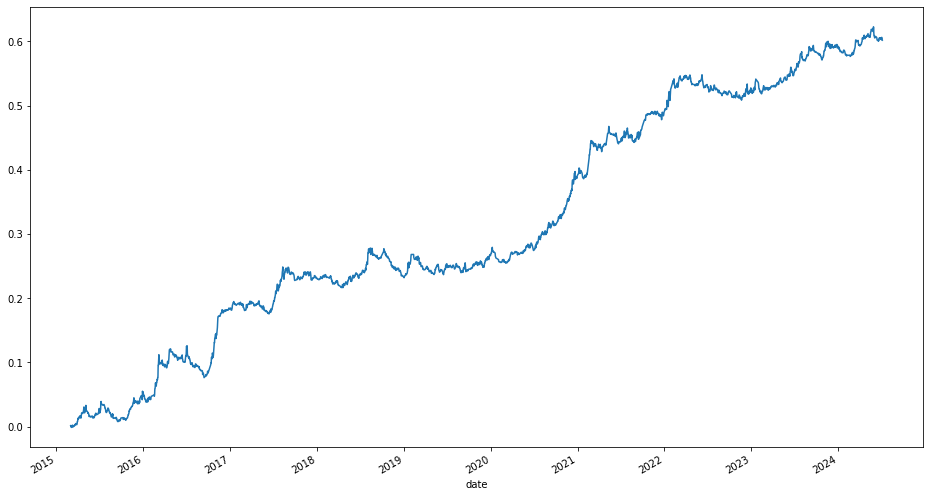

In [6]:
engine.clear_data()
setting = {
    "window": 100,
    "stm_width": 0.8,
    "ls_imba": 0.75,
    "atr_multiplier": 13,
}
engine.add_strategy(TSStrategy, setting)

engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()

daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
daily_base.cumsum().plot(figsize=(16, 9))
calc_sharpe(daily_base)

In [7]:
trade_info = []
for trade in engine.trades.values():
    trade_info.append(
        {
            'symbol': trade.symbol,
            'direction': trade.direction,
            'offset': trade.offset,
            'price': trade.price,
            'volume': trade.volume,
            'datetime': trade.datetime,
        }
    )

trade_info = pd.DataFrame(trade_info)

rounds = []
for symbol, group in trade_info.groupby('symbol'):
    round_ = pd.DataFrame(columns=['symbol', 'direction', 'open_time', 'open_price', 'close_time', 'close_price', 'volume', 'pnl', 'hp'])
    idx = 0
    
    try:
        for i in range(0, len(group), 2):
            open_trade = group.iloc[i, :]
            close_trade = group.iloc[i + 1, :]
            
            direction = 1 if open_trade['direction'] == Direction.LONG else -1
            
            round_.loc[idx, 'symbol'] = symbol
            round_.loc[idx, 'direction'] = open_trade['direction']
            round_.loc[idx, 'open_time'] = open_trade['datetime']
            round_.loc[idx, 'open_price'] = open_trade['price']
            round_.loc[idx, 'close_time'] = close_trade['datetime']
            round_.loc[idx, 'close_price'] = close_trade['price']
            round_.loc[idx, 'volume'] = open_trade['volume']
            round_.loc[idx, 'pnl'] = (close_trade['price'] - open_trade['price']) / open_trade['price'] * direction
            round_.loc[idx, 'hp'] = (close_trade['datetime'] - open_trade['datetime']).total_seconds() / dt.timedelta(days=1).total_seconds()
            
            idx += 1
    
    except IndexError:
        pass
    
    rounds.append(round_)
    
rounds = pd.concat(rounds)

desc = rounds[['hp', 'pnl']].astype(float).describe(include='all')

loc = rounds['direction'] == Direction.LONG
desc_long = rounds[loc][['hp', 'pnl']].astype(float).describe(include='all')
desc = desc.merge(desc_long, suffixes=('', '_long'), left_index=True, right_index=True)

loc = rounds['direction'] == Direction.SHORT
desc_short = rounds[loc][['hp', 'pnl']].astype(float).describe(include='all')
desc = desc.merge(desc_short, suffixes=('', '_short'), left_index=True, right_index=True)

desc

,hp,pnl,hp_long,pnl_long,hp_short,pnl_short
count,2532.000000,2532.000000,1476.000000,1476.000000,1056.000000,1056.000000
mean,19.483474,0.007979,23.686872,0.012779,13.608270,0.001269
std,17.113215,0.063425,19.114835,0.073930,11.510279,0.043953
min,0.010417,-0.129717,0.010417,-0.129717,0.031250,-0.087721
25%,7.434896,-0.028922,9.916667,-0.030993,5.979167,-0.026205
50%,14.015625,-0.008405,17.760417,-0.008059,10.015625,-0.009182
75%,26.557292,0.026210,32.992188,0.033403,18.091146,0.018907
max,119.010417,0.650470,119.010417,0.650470,83.677083,0.269863


## Optimization

In [8]:
from vnpy.app.vnpy_portfoliostrategy.strategies.ts_strategy import TSStrategy as TSStrategy_

In [9]:
setting = {
    "window": 50,
}
engine.clear_data()
engine.add_strategy(TSStrategy_, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 100, 900, 100)
setting.add_parameter("atr_multiplier", 9, 15, 2)
setting.add_parameter("ls_imba", 0.75)

opt_res = engine.run_bf_optimization(setting, max_workers=10)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['atr_multiplier']] = sharpe

sharpe_mat.sort_index().sort_index(axis=1)

2024-07-06 21:09:53.329511	开始执行穷举算法优化
2024-07-06 21:09:53.329511	参数优化空间：36


100%|██████████| 36/36 [17:21<00:00, 28.94s/it]  


2024-07-06 21:27:19.484680	穷举算法优化完成，耗时1046秒
2024-07-06 21:27:24.581383	参数：{'window': 100, 'atr_multiplier': 15, 'ls_imba': 0.75}, 目标：1.3886711137223673
2024-07-06 21:27:24.582380	参数：{'window': 100, 'atr_multiplier': 13, 'ls_imba': 0.75}, 目标：1.3573572575303818
2024-07-06 21:27:24.582380	参数：{'window': 700, 'atr_multiplier': 13, 'ls_imba': 0.75}, 目标：1.308967481179079
2024-07-06 21:27:24.582380	参数：{'window': 300, 'atr_multiplier': 15, 'ls_imba': 0.75}, 目标：1.2297867916075913
2024-07-06 21:27:24.582380	参数：{'window': 100, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：1.2248089314533093
2024-07-06 21:27:24.582380	参数：{'window': 400, 'atr_multiplier': 15, 'ls_imba': 0.75}, 目标：1.209750846459356
2024-07-06 21:27:24.582380	参数：{'window': 700, 'atr_multiplier': 15, 'ls_imba': 0.75}, 目标：1.1986457271947397
2024-07-06 21:27:24.582380	参数：{'window': 700, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：1.19281307302758
2024-07-06 21:27:24.582380	参数：{'window': 500, 'atr_multiplier': 15, 'ls_imba': 0.75}, 目标：1.17190

,9,11,13,15
100,1.025711,1.224809,1.357357,1.388671
200,0.809233,0.957587,0.982844,1.100435
300,1.012915,1.036081,1.028269,1.229787
400,0.916909,1.079219,1.105326,1.209751
500,0.629590,0.906985,1.082795,1.171903
600,0.713303,1.032573,1.101961,1.138281
700,0.926233,1.192813,1.308967,1.198646
800,0.908360,0.927525,1.030676,0.861332
900,0.715519,0.910005,0.912821,0.675345


## Param Selected

2024-07-06 21:42:44.812626	策略初始化完成
2024-07-06 21:42:44.814621	开始回放历史数据


回放历史数据:   0%|          | 0/68810 [00:00<?, ?it/s]

2024-07-06 21:44:04.541012	历史数据回放结束
2024-07-06 21:44:04.541012	开始计算逐日盯市盈亏
2024-07-06 21:44:04.659694	逐日盯市盈亏计算完成
2024-07-06 21:44:04.830238	策略初始化完成
2024-07-06 21:44:04.831235	开始回放历史数据


回放历史数据:   0%|          | 0/68810 [00:00<?, ?it/s]

2024-07-06 21:45:24.631644	历史数据回放结束
2024-07-06 21:45:24.631644	开始计算逐日盯市盈亏
2024-07-06 21:45:24.751828	逐日盯市盈亏计算完成
2024-07-06 21:45:24.916387	策略初始化完成
2024-07-06 21:45:24.918382	开始回放历史数据


回放历史数据:   0%|          | 0/68810 [00:00<?, ?it/s]

2024-07-06 21:46:45.143624	历史数据回放结束
2024-07-06 21:46:45.144621	开始计算逐日盯市盈亏
2024-07-06 21:46:45.262307	逐日盯市盈亏计算完成
2024-07-06 21:46:45.786421	策略初始化完成
2024-07-06 21:46:45.788416	开始回放历史数据


回放历史数据:   0%|          | 0/66716 [00:00<?, ?it/s]

2024-07-06 21:48:20.156808	历史数据回放结束
2024-07-06 21:48:20.156808	开始计算逐日盯市盈亏
2024-07-06 21:48:20.272498	逐日盯市盈亏计算完成
2024-07-06 21:48:20.794617	策略初始化完成
2024-07-06 21:48:20.796612	开始回放历史数据


回放历史数据:   0%|          | 0/66716 [00:00<?, ?it/s]

2024-07-06 21:49:56.192956	历史数据回放结束
2024-07-06 21:49:56.192956	开始计算逐日盯市盈亏
2024-07-06 21:49:56.305654	逐日盯市盈亏计算完成
2024-07-06 21:49:56.832245	策略初始化完成
2024-07-06 21:49:56.833243	开始回放历史数据


回放历史数据:   0%|          | 0/66716 [00:00<?, ?it/s]

2024-07-06 21:51:32.524682	历史数据回放结束
2024-07-06 21:51:32.524682	开始计算逐日盯市盈亏
2024-07-06 21:51:32.639375	逐日盯市盈亏计算完成
2024-07-06 21:51:33.680650	策略初始化完成
2024-07-06 21:51:33.681647	开始回放历史数据


回放历史数据:   0%|          | 0/64903 [00:00<?, ?it/s]

2024-07-06 21:53:24.593078	历史数据回放结束
2024-07-06 21:53:24.593078	开始计算逐日盯市盈亏
2024-07-06 21:53:24.707436	逐日盯市盈亏计算完成
2024-07-06 21:53:25.762186	策略初始化完成
2024-07-06 21:53:25.764181	开始回放历史数据


回放历史数据:   0%|          | 0/64903 [00:00<?, ?it/s]

2024-07-06 21:55:17.772067	历史数据回放结束
2024-07-06 21:55:17.772067	开始计算逐日盯市盈亏
2024-07-06 21:55:17.882771	逐日盯市盈亏计算完成
2024-07-06 21:55:18.919175	策略初始化完成
2024-07-06 21:55:18.921200	开始回放历史数据


回放历史数据:   0%|          | 0/64903 [00:00<?, ?it/s]

2024-07-06 21:57:12.135693	历史数据回放结束
2024-07-06 21:57:12.135693	开始计算逐日盯市盈亏
2024-07-06 21:57:12.246397	逐日盯市盈亏计算完成
2024-07-06 21:57:13.971873	策略初始化完成
2024-07-06 21:57:13.973868	开始回放历史数据


回放历史数据:   0%|          | 0/63091 [00:00<?, ?it/s]

2024-07-06 21:59:19.505550	历史数据回放结束
2024-07-06 21:59:19.505550	开始计算逐日盯市盈亏
2024-07-06 21:59:19.610271	逐日盯市盈亏计算完成
2024-07-06 21:59:21.309801	策略初始化完成
2024-07-06 21:59:21.311796	开始回放历史数据


回放历史数据:   0%|          | 0/63091 [00:00<?, ?it/s]

2024-07-06 22:01:27.159588	历史数据回放结束
2024-07-06 22:01:27.159588	开始计算逐日盯市盈亏
2024-07-06 22:01:27.264308	逐日盯市盈亏计算完成
2024-07-06 22:01:28.973842	策略初始化完成
2024-07-06 22:01:28.975836	开始回放历史数据


回放历史数据:   0%|          | 0/63091 [00:00<?, ?it/s]

2024-07-06 22:03:36.393251	历史数据回放结束
2024-07-06 22:03:36.393251	开始计算逐日盯市盈亏
2024-07-06 22:03:36.497971	逐日盯市盈亏计算完成


<AxesSubplot:xlabel='date'>

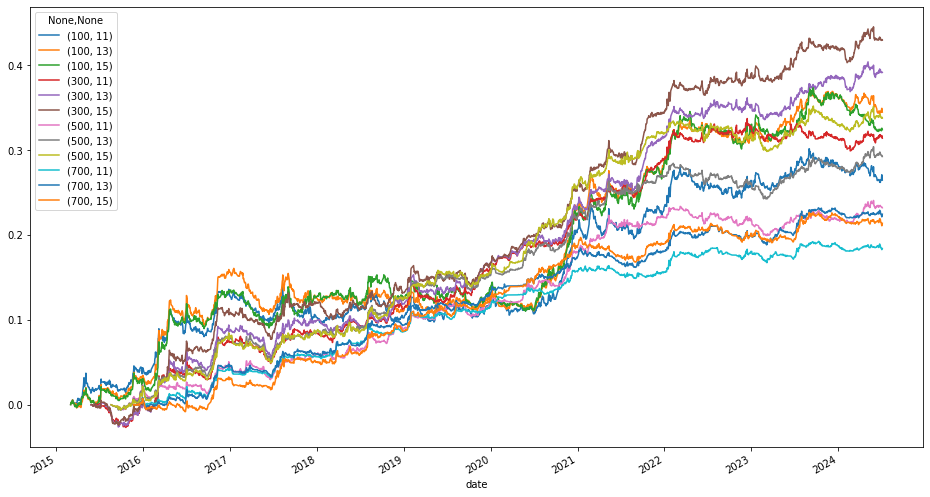

In [10]:
windows = [100, 300, 500, 700]
atr_multipliers = [11, 13, 15]

navs = {}
for window in windows:
    for atr_multiplier in atr_multipliers:
        setting = {
            "window": window,
            "atr_multiplier": atr_multiplier,
            "ls_imba": 0.75,
        }
        
        engine.clear_data()
        engine.add_strategy(TSStrategy, setting)

        engine.run_backtesting()
        df = engine.calculate_result()
        
        daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
        navs[(window, atr_multiplier)] = daily_base
        
selected_nav = pd.DataFrame(navs)
selected_nav.cumsum().plot(figsize=(16, 9))

<AxesSubplot:xlabel='date'>

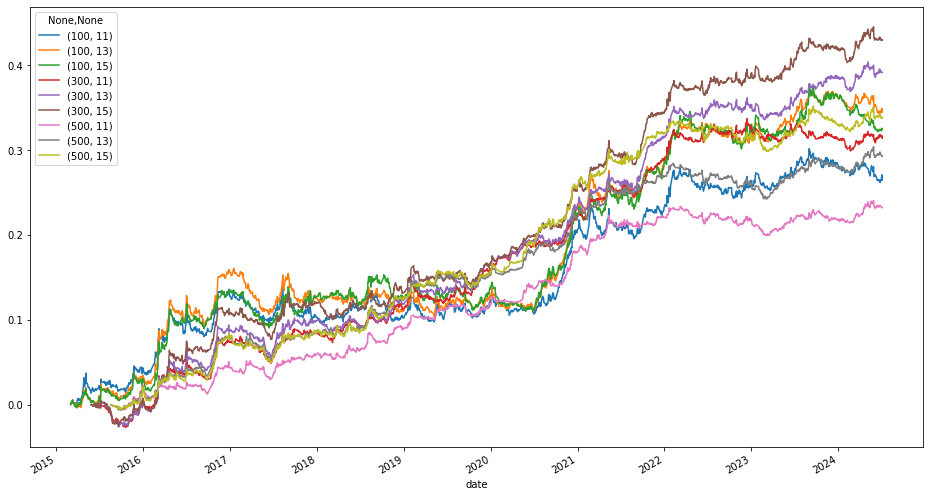

In [11]:
selected_nav.iloc[:, :-3].cumsum().plot(figsize=(16, 9))

In [20]:
selected_nav

100                           300                      \
                  11        13        15        11        13        15   
date                                                                     
2015-03-02  0.000269  0.000269  0.000269       NaN       NaN       NaN   
2015-03-03  0.001612  0.001612  0.001612       NaN       NaN       NaN   
2015-03-04  0.000465  0.000465  0.000465       NaN       NaN       NaN   
2015-03-05 -0.000679 -0.000679 -0.000679       NaN       NaN       NaN   
2015-03-06  0.002247  0.002060  0.001612       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-07-01 -0.000097 -0.000982 -0.001638 -0.000649 -0.000633 -0.000778   
2024-07-02  0.003764  0.003349  0.002598  0.000319  0.000203  0.000504   
2024-07-03  0.002505  0.001031  0.000475  0.001338  0.000230  0.000073   
2024-07-04 -0.003292 -0.002882 -0.000993 -0.001776  0.000293  0.000532   
2024-07-05 -0.003048 -0.001661 -0.000727 -0.001353 -0.000397 -0.000465   

                 500                           700                      
                  11        13        15        11        13        15  
date                                                                    
2015-03-02       NaN       NaN       NaN       NaN       NaN       NaN  
2015-03-03       NaN       NaN       NaN       NaN       NaN       NaN  
2015-03-04       NaN       NaN       NaN       NaN       NaN       NaN  
2015-03-05       NaN       NaN       NaN       NaN       NaN       NaN  
2015-03-06       NaN       NaN       NaN       NaN       NaN       NaN  
...              ...       ...       ...       ...       ...       ...  
2024-07-01 -0.000629 -0.000764 -0.001068 -0.000608 -0.000862 -0.001429  
2024-07-02 -0.000216 -0.000220 -0.000236 -0.000869 -0.001485 -0.001844  
2024-07-03 -0.000037  0.000054 -0.000059 -0.000755 -0.000937 -0.001050  
2024-07-04  0.000019  0.000209  0.001062  0.000622  0.002423  0.002359  
2024-07-05 -0.000686 -0.001259 -0.000661  0.000756  0.000732  0.000620  

[2679 rows x 12 columns]

## Correlation

In [12]:
from Pandora.data_manager import get_api

api = get_api()

info = api.get_backtest_info()
loc = (info['StrategyName'] == 'STM') & (info['BackTestId'].str.contains('Trace'))
info.loc[loc, 'StrategyName'] = 'STM_Trace'

info

,BackTestId,StrategyName,TargetVol,Weight,Params,UpdateTime
0,Argmin_500-MM-CrossMA_11,ArgminCrossMA,0.05,0.055576,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-05 20:37:27.657
1,Argmin_500-MM-CrossMA_11_LSImba_0.75,ArgminCrossMA,0.05,0.053080,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-05 20:37:27.650
2,Argmin_500-SHORT-CrossMA_11,ArgminCrossMA,0.05,0.047293,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-05 20:31:03.427
3,Argmin_500-SHORT-CrossMA_11_LSImba_0.75,ArgminCrossMA,0.05,0.045085,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-05 20:31:03.417
4,Argmin_500-SHORT-CrossMA_13,ArgminCrossMA,0.05,0.045173,"{'window': 500, 'atr_multiplier': 13, 'ls_imba...",2024-07-05 20:31:03.430
...,...,...,...,...,...,...
609,WILLR_STM_V0_260_240-MA_240-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.046078,"{'ma_window': 240, 'rebal': 5, 'n_group': 5}",2024-07-05 20:07:18.737
610,WILLR_STM_V0_280_220-MA_220-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.045440,"{'ma_window': 220, 'rebal': 5, 'n_group': 5}",2024-07-05 20:07:18.740
611,WILLR_STM_V0_300_180-MA_180-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.045029,"{'ma_window': 180, 'rebal': 5, 'n_group': 5}",2024-07-05 20:07:18.743
612,WILLR_STM_V0_300_200-MA_200-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.045048,"{'ma_window': 200, 'rebal': 5, 'n_group': 5}",2024-07-05 20:07:18.743


In [13]:
info['StrategyName'].unique()

array(['ArgminCrossMA', 'BasisMom', 'Close', 'CpvCorr', 'CpvTsrank',
       'MACDBBand', 'MOM_STM', 'NsSlope', 'OlsMtRes', 'PSARK',
       'RollYield', 'Rotary', 'STM_BIAS', 'STM_Trace', 'STM', 'WILLR_STM'],
      dtype=object)

In [14]:
strategies = [
    'ArgminCrossMA', 'Close', 'MACDBBand', 'PSARK', 'STM', 'STM_Trace',
    'MOM_STM', 'STM_BIAS', 'WILLR_STM',
    'NsSlope', 'OlsMtRes', 'RollYield', 
    # 'Rotary'
]

In [15]:
import pandas as pd

strategy_nav = {}
for name, group in info.groupby('StrategyName'):
    if name not in strategies:
        continue
    
    navs = {}
    for i in group.index:
        id_ = group.loc[i, 'BackTestId']
        df = api.get_backtest_ret(id_)
        
        navs[id_] = df.set_index('DateTime')['Ret']
        
    
    strategy_nav[name] = pd.DataFrame(navs).mean(axis=1)
 

In [16]:
strategy_nav['tsstrategy'] = selected_nav.mean(axis=1)

In [17]:
pd.DataFrame(strategy_nav).fillna(0).corr()

,ArgminCrossMA,Close,MACDBBand,MOM_STM,NsSlope,OlsMtRes,PSARK,RollYield,STM,STM_BIAS,STM_Trace,WILLR_STM,tsstrategy
ArgminCrossMA,1.000000,0.328649,0.748904,0.008001,0.012188,0.027248,0.467542,-0.030662,0.550757,-0.036163,0.403281,0.009095,0.690988
Close,0.328649,1.000000,0.241399,-0.010242,0.000798,-0.001810,0.845517,-0.013504,0.539466,0.025689,0.791382,-0.012796,0.259406
MACDBBand,0.748904,0.241399,1.000000,0.031454,0.033506,0.044286,0.426331,-0.006663,0.523006,-0.032203,0.336742,0.026895,0.880368
MOM_STM,0.008001,-0.010242,0.031454,1.000000,0.211920,0.098459,-0.008941,0.225501,-0.002126,0.637520,-0.001297,0.793766,0.029262
NsSlope,0.012188,0.000798,0.033506,0.211920,1.000000,0.653839,-0.001073,0.778216,-0.009135,0.323377,0.009009,0.389326,0.032657
OlsMtRes,0.027248,-0.001810,0.044286,0.098459,0.653839,1.000000,0.013873,0.544401,0.024568,0.189474,0.018655,0.263345,0.043461
PSARK,0.467542,0.845517,0.426331,-0.008941,-0.001073,0.013873,1.000000,-0.024275,0.651150,-0.001992,0.814244,-0.014991,0.410360
RollYield,-0.030662,-0.013504,-0.006663,0.225501,0.778216,0.544401,-0.024275,1.000000,-0.077183,0.467650,-0.015947,0.489113,0.000576
STM,0.550757,0.539466,0.523006,-0.002126,-0.009135,0.024568,0.651150,-0.077183,1.000000,-0.036090,0.626293,-0.027861,0.497291
STM_BIAS,-0.036163,0.025689,-0.032203,0.637520,0.323377,0.189474,-0.001992,0.467650,-0.036090,1.000000,0.001045,0.785652,-0.012940


<AxesSubplot:>

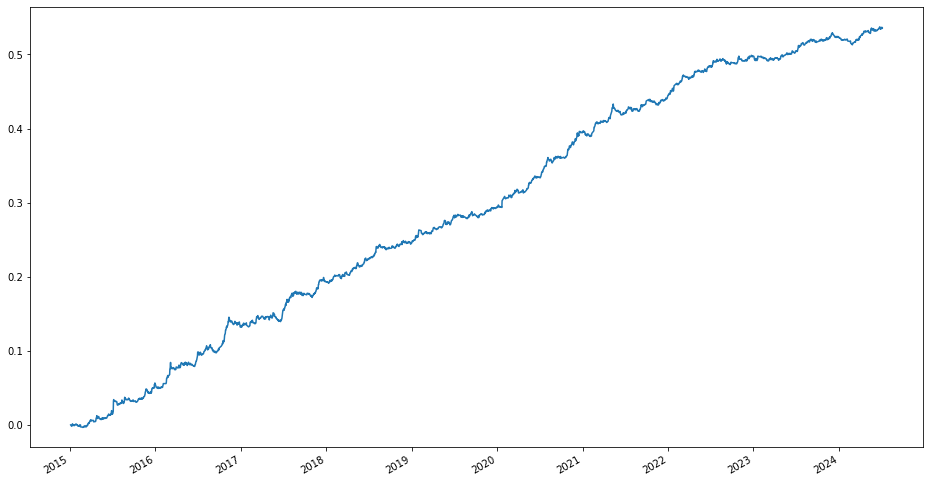

In [18]:
pd.DataFrame(strategy_nav).fillna(0).mean(axis=1).cumsum().plot(figsize=(16, 9))

<AxesSubplot:>

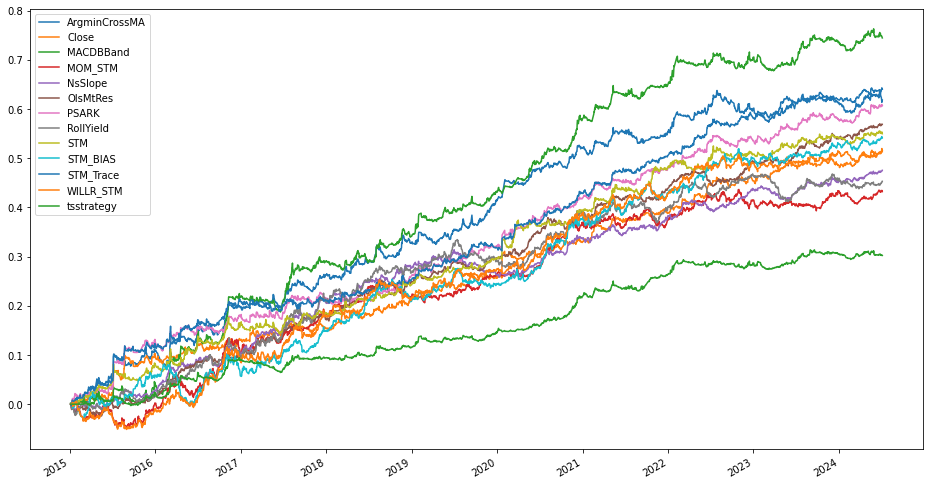

In [19]:
pd.DataFrame(strategy_nav).fillna(0).cumsum().plot(figsize=(16, 9))